In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from numpy.random import randn

In [2]:
tf.keras.backend.clear_session()

## Defining a sampler

In [3]:
def sample_data(n=10000, scale=100, y0=10):
   "generator of data sampled from a parabola centered in 0"
   x = scale*(np.random.random_sample((n)) - 0.5)
   y = y0 + x**2
   return np.column_stack((x, y))

def generate_real_samples(n, scale=100, y0=10):
   "generate n real samples with class labels"
   X = sample_data(n, scale, y0)
   labels = np.ones((n, 1))
   return X, labels

Text(0.5, 1.0, '100 samples')

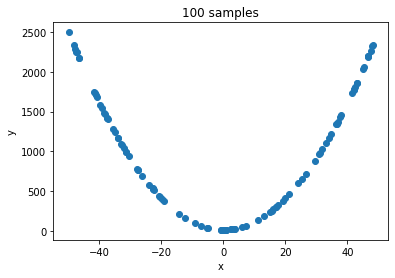

In [4]:
n = 100
data, _ = generate_real_samples(n)
plt.scatter(data[:,0], data[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'{n} samples')

## Defining a discriminator

In [5]:
def get_discriminator(n_inputs=2):
    "define and compile a discriminator model"
    model = Sequential()
    model.add(Dense(16, activation=tf.nn.leaky_relu, input_dim=n_inputs))
    model.add(Dense(16, activation=tf.nn.leaky_relu))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='RMSprop', 
                  metrics=['accuracy'])
    return model

In [6]:
D = get_discriminator()
D.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


## Defining a generator

In [9]:
def define_generator(input_dim, n_outputs=2):
    "define a generator model that maps from input_dim to n_outputs"
    model = Sequential()
    model.add(Dense(16, activation=tf.nn.leaky_relu, input_dim=input_dim))
    model.add(Dense(16, activation=tf.nn.leaky_relu))
    model.add(Dense(n_outputs, activation='linear'))
    return model

In [10]:
def generate_latent_points(latent_dim, n):
    "generate points in latent space as input for the generator"
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

def generate_fake_samples(generator, latent_dim, n):
      "generate n fake examples from the generator"
      x_input = generate_latent_points(latent_dim, n)
      X = generator.predict(x_input)
      y = np.zeros((n, 1))
      return X, y

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 578
Trainable params: 578
Non-trainable params: 0
_________________________________________________________________


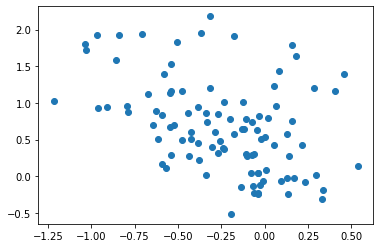

In [11]:
latent_dim = 16
G = define_generator(latent_dim)
G.summary()

# generate and plot generated samples
X, _ = generate_fake_samples(G, latent_dim, 100)
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [63]:
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [64]:
# size of the latent space
latent_dim = 16
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# summarize gan model
gan_model.summary()


Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_45 (Sequential)   (None, 2)                 578       
_________________________________________________________________
sequential_44 (Sequential)   (None, 1)                 337       
Total params: 915
Trainable params: 578
Non-trainable params: 337
_________________________________________________________________


In [65]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print("Iterations: %d\t Discriminator acc on real: %.4f\t" 
         "Discriminator acc on fake: %.4f"%(epoch, acc_real, acc_fake))
    # scatter plot real and fake data points
    plt.scatter(x_real[:, 0], x_real[:, 1], color='orange')
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    plt.show()

In [66]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=256, 
          n_eval=2000, d_step=5):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        for j in range(d_step):
          d_model.train_on_batch(x_real, y_real)
          d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Iterations: 1999	 Discriminator acc on real: 0.6800	Discriminator acc on fake: 0.9700


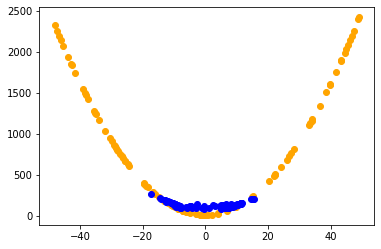

Iterations: 3999	 Discriminator acc on real: 0.4000	Discriminator acc on fake: 0.9900


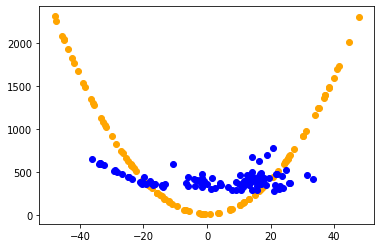

Iterations: 5999	 Discriminator acc on real: 0.1300	Discriminator acc on fake: 0.9800


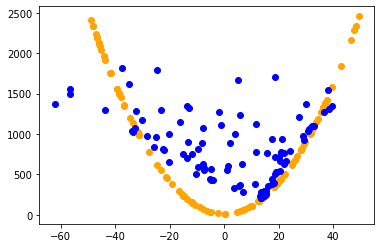

Iterations: 7999	 Discriminator acc on real: 0.0800	Discriminator acc on fake: 0.9400


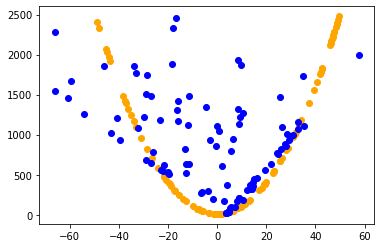

Iterations: 9999	 Discriminator acc on real: 0.3400	Discriminator acc on fake: 0.5700


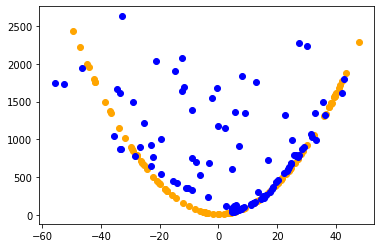

In [67]:
# size of the latent space
latent_dim = 2
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)